# Text Mining - Final Report - Topic Extraction/Modeling
Due 7th june by midnight

In [1]:
directory_path = ''
# Setup for Colab
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab, downloading all the data')
  # Download the full dataset
  !wget -nc https://github.com/tommcamm/aut-text-mining/raw/main/Assignment/code/Dataset/Assignment2BlogData.zip -P Dataset # full dataset
  !unzip -n -q ./Dataset/Assignment2BlogData.zip -d ./Dataset # unzip the dataset
  directory_path = './Dataset/blogs'

  # download the pre-processed datasets
  ## -nc avoid to download the file if already present, -P is the directory where the file will be placed
  !wget -nc https://github.com/tommcamm/aut-text-mining/raw/main/Assignment/code/PreProcessed/students_preprocessed.pkl.gz -P PreProcessed # students pre-processed
  !wget -nc https://github.com/tommcamm/aut-text-mining/raw/main/Assignment/code/PreProcessed/under_20s_preprocessed.pkl.gz -P PreProcessed # under 20s pre-processed
  !wget -nc https://github.com/tommcamm/aut-text-mining/raw/main/Assignment/code/PreProcessed/females_preprocessed.pkl.gz -P PreProcessed # females pre-processed
  !wget -nc https://github.com/tommcamm/aut-text-mining/raw/main/Assignment/code/PreProcessed/males_preprocessed.pkl.gz -P PreProcessed # males pre-processed
  !wget -nc https://github.com/tommcamm/aut-text-mining/raw/main/Assignment/code/PreProcessed/over_20s_preprocessed.pkl.gz -P PreProcessed # over 20s pre-processed
  !wget -nc https://github.com/tommcamm/aut-text-mining/raw/main/Assignment/code/PreProcessed/everyone_preprocessed.pkl.gz -P PreProcessed # Everyone pre-processed

  # Download the test data - two files
  !wget -nc https://raw.githubusercontent.com/tommcamm/aut-text-mining/main/Assignment/code/TestDir/23676.male.33.Technology.Scorpio.xml -P TestDir
  !wget -nc https://raw.githubusercontent.com/tommcamm/aut-text-mining/main/Assignment/code/TestDir/5114.male.25.indUnk.Scorpio.xml -P TestDir

  !pip install bertopic
else:
  print(f'Not running on CoLab, skipping download. (environment: {str(get_ipython())})')
  # For this step I assume the data is already there
  # !unzip ./Dataset/Assignment2BlogData.zip -d ./Dataset # unzip the dataset
  directory_path = './Dataset/blogs'
  !python -m spacy download en_core_web_sm

Not running on CoLab, skipping download. (environment: <ipykernel.zmqshell.ZMQInteractiveShell object at 0x000001D784F30D90>)
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 682.7 kB/s eta 0:00:19
      --------------------------------------- 0.3/12.8 MB 3.9 MB/s eta 0:00:04
     ----- ---------------------------------- 1.9/12.8 MB 14.9 MB/s eta 0:00:01
     ------------ --------------------------- 3.9/12.8 MB 22.8 MB/s eta 0:00:01
     ------------------ --------------------- 5.9/12.8 MB 26.7 MB/s eta 0:00:01
     ------------------------ --------------- 7.8/12.8 MB 29.3 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 29.8 MB/s eta 0:00:01
     -------------------------- ------------- 8.4/12.8 MB 29.8 MB/s eta 0:00:01
     ------------------------------ -------- 10.1/12.8 MB 24.7 MB/s eta 0:00:01
     ---------------------------------- ---- 11.4/12.8 MB 31.2 MB/s eta 0:00:01
   

## Data cleaning
The following steps will be applied to the dataset to ensure it is cleaned.
1. Remove Non-ASCII Characters: Ensures text is ASCII encoded.
2. Remove Punctuation: Removes any punctuation marks.
3. Lowercase Conversion: Converts all text to lowercase.
4. Remove Stopwords: Removes common stopwords that do not contribute to the meaning of the text.
5. Tokenization: Splits text into individual words.
6. Lemmatization: Reduces words to their base or root form.

In [2]:
import spacy
import re
import nltk
import os
import chardet
import concurrent.futures
from tqdm import tqdm
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# This command must be run before: python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

date_re = re.compile(r'<date>.*?</date>', re.DOTALL)
html_tag_re = re.compile(r'<[^>]+>', re.DOTALL)
url_link_re = re.compile(r'urlLink', re.DOTALL)

# Basic Text Pre-Processing pipeline - Useful for NTMs
def preprocess_text_basic(text):
    # 1. Remove all XML tags from the document (along with the date)
    text = date_re.sub('', text)  # Remove dates
    text = html_tag_re.sub('', text)  # Remove HTML tags
    text = url_link_re.sub('', text)  # Remove urlLink(s)

    # Convert to ASCII and lowercasing to make it case-insensitive
    text = text.encode('ascii', 'ignore').decode('ascii')
    text = text.lower()

    return text

# Pre-Process pipeline using spacy for GPU
def preprocess_text_spacy(text):
    text = preprocess_text_basic(text)

    # Process the text with SpaCy
    doc = nlp(text)

    # Remove stopwords and perform lemmatization
    cleaned_tokens = [
        (token.lemma_, token.pos_)
        for token in doc
        if not token.is_stop and (token.is_alpha or token.is_punct)  # keep punct
    ]

    return cleaned_tokens

# Pre-Process pipeline using spacy for GPU
def preprocess_text_spacy_deepl(text):
    text = preprocess_text_basic(text)

    # Process the text with SpaCy
    doc = nlp(text)

    # Keep tokens as they are (no lemmatization), including stop words and punctuation
    cleaned_tokens = [
        (token.text, token.pos_)
        for token in doc
        if (token.is_alpha or token.is_punct)
    ]

    return cleaned_tokens

def process_file(filepath, use_deepl):
    try:
        with open(filepath, 'rb') as f:
            raw_data = f.read()
            result = chardet.detect(raw_data)
            encoding = result['encoding']
            text = raw_data.decode(encoding)
            cleaned_text = preprocess_text_spacy_deepl(text) if use_deepl else preprocess_text_spacy(text)
            return cleaned_text, None
    except Exception as e:
        return None, (filepath, str(e))

def extract_and_preprocess_text_from_directory(directory_path, use_deepl=False, num_workers=10, filter_func=None):
    text_data = []
    failed_files = []
    filepaths = [os.path.join(directory_path, filename) for filename in os.listdir(directory_path)]

    if filter_func:
        filepaths = [fp for fp in filepaths if filter_func(fp)]

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = {executor.submit(process_file, filepath, use_deepl): filepath for filepath in filepaths}
        with tqdm(total=len(filepaths), desc="Processing files") as pbar:
            for future in concurrent.futures.as_completed(futures):
                cleaned_text, error = future.result()
                if cleaned_text:
                    text_data.append(cleaned_text)
                else:
                    failed_files.append(error)
                pbar.update(1)
    return text_data, failed_files

# Helper functions
def get_tokens_without_pos(doc):
    """
    Extracts tokens without POS tags from the document.

    :param doc: List of tuples (token, pos_tag)
    :return: List of tokens
    """
    return [token for token, _ in doc]

def get_text_from_tokens(doc):
    """
    Constructs a string from tokens without POS tags.

    :param doc: List of tuples (token, pos_tag)
    :return: String of concatenated tokens
    """
    tokens_only = get_tokens_without_pos(doc)
    return ' '.join(tokens_only)


In [3]:
# Test of the pre-processor on one file
test_dir = 'TestDir'
text_data_test, failed_data_test = extract_and_preprocess_text_from_directory(test_dir)
text_data_deepl, failed_deepl = extract_and_preprocess_text_from_directory(test_dir, use_deepl=True)

print('\n[LEMMA] TEST RESULTS')
for doc in text_data_test:
    print("-> ", get_text_from_tokens(doc[:20]))

print('[LEMMA] POS TAGS')
for doc in text_data_test:
    print("-> ", doc[:10])

print(failed_deepl)
print('[DEEPL] TEST RESULTS')
for doc in text_data_deepl:
    print("-> ", get_text_from_tokens(doc[:20]))

print('[DEEPL] POST TAGS')
for doc in text_data_deepl:
    print("-> ", doc[:10])


Processing files: 100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


[LEMMA] TEST RESULTS
->  hello ! run finally end smooth win static . congrat , gil box quick sell ni . wednesday hold xping
->  ok . idea stupid idea think . overwhelming desire create website work . listen hot snake automatic midnight right .
->  slashdot raise lot interesting thought banner ad . idea let user control ad delivery , allow user comment ad .
->  wish high school : wireless networking ti graph calculator . high school , graph calculator game save sanity . go
[LEMMA] POS TAGS
->  [('hello', 'INTJ'), ('!', 'PUNCT'), ('run', 'NOUN'), ('finally', 'ADV'), ('end', 'VERB'), ('smooth', 'ADJ'), ('win', 'NOUN'), ('static', 'NOUN'), ('.', 'PUNCT'), ('congrat', 'NOUN')]
->  [('ok', 'INTJ'), ('.', 'PUNCT'), ('idea', 'NOUN'), ('stupid', 'ADJ'), ('idea', 'NOUN'), ('think', 'VERB'), ('.', 'PUNCT'), ('overwhelming', 'ADJ'), ('desire', 'NOUN'), ('create', 'VERB')]
->  [('slashdot', 'NOUN'), ('raise', 'VERB'), ('lot', 'NOUN'), ('interesting', 'ADJ'), ('thought', 'NOUN'), ('banner', 'NOUN')

In [4]:
# Filters for the pre-processor

import gzip
import pickle

def filter_everyone(filepath):
    return True

def filter_student(filepath):
    filename = os.path.basename(filepath)
    return '.Student.' in filename

def filter_female(filepath):
    filename = os.path.basename(filepath)
    return '.female.' in filename

def filter_male(filepath):
    filename = os.path.basename(filepath)
    return '.male.' in filename

def filter_age_over_20(filepath):
    filename = os.path.basename(filepath)
    try:
        age = int(filename.split('.')[2])
        return age > 20
    except ValueError:
        return False

def filter_age_under_20(filepath):
    filename = os.path.basename(filepath)
    try:
        age = int(filename.split('.')[2])
        return age <= 20
    except ValueError:
        return False

#  Helper function to work with the pre-processed data
#  (they would be much bigger)
def save_compressed_pickle(data, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_compressed_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        return pickle.load(f)

In [ ]:
# Process "Students"
#text_data_students, failed_files_students = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_student)
#save_compressed_pickle(text_data_students, 'students_preprocessed_punct.pkl.gz')
#text_data_students_deepl, failed_files_students_deepl = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_student, use_deepl=True)
#save_compressed_pickle(text_data_students_deepl, 'students_preprocessed_deepl.pkl.gz')

#%reset_selective -f "^text_data_students*$"

# Process "under 20s"
#text_data_under_20s, failed_files_under_20s = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_age_under_20)
#save_compressed_pickle(text_data_under_20s, 'under_20s_preprocessed_punct.pkl.gz')
#text_data_under_20s_deepl, failed_files_under_20s_deepl = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_age_under_20, use_deepl=True)
#save_compressed_pickle(text_data_under_20s_deepl, 'under_20s_preprocessed_deepl.pkl.gz')

#%reset_selective -f "^text_data_under_20s*$"

# Process "males"
#text_data_males, failed_files_males = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_male)
#save_compressed_pickle(text_data_males, 'males_preprocessed_punct.pkl.gz')
text_data_males_deepl, failed_files_males_deepl = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_male, use_deepl=True)
save_compressed_pickle(text_data_males_deepl, 'males_preprocessed_deepl.pkl.gz')

%reset_selective -f "^text_data_males*$"

# Process "females"
text_data_females, failed_files_females = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_female)
save_compressed_pickle(text_data_females, 'females_preprocessed_punct.pkl.gz')
text_data_females_deepl, failed_files_females_deepl = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_female, use_deepl=True)
save_compressed_pickle(text_data_females_deepl, 'females_preprocessed_deepl.pkl.gz')

%reset_selective -f "^text_data_females*$"

# Process "Over 20s"
text_data_over_20s, failed_files_over_20s = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_age_over_20)
save_compressed_pickle(text_data_over_20s, 'over_20s_preprocessed_punct.pkl.gz')
text_data_over_20s_deepl, failed_files_over_20s_deepl = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_age_over_20, use_deepl=True)
save_compressed_pickle(text_data_over_20s_deepl, 'over_20s_preprocessed_deepl.pkl.gz')

%reset_selective -f "^text_data_over_20s*$"

# Process "Everyone" - If RAM >= 30GB && CPU_Cores > 10 --> approx 2h (colab not recommended (cpu_cores = 2))
text_data_everyone, failed_files_everyone = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_everyone)
save_compressed_pickle(text_data_everyone, 'everyone_preprocessed_punct.pkl.gz')
text_data_everyone_deepl, failed_files_everyone_deepl = extract_and_preprocess_text_from_directory(directory_path, filter_func=filter_everyone, use_deepl=True)
save_compressed_pickle(text_data_everyone_deepl, 'everyone_preprocessed_deepl.pkl.gz')

%reset_selective -f "^text_data_everyone*$"

Processing files:   3%|▎         | 330/9660 [08:00<3:46:30,  1.46s/it]


In [5]:
# Load of all pre-processed files
# WARNING: Uses lot of RAM, High-RAM or only one file at a time recommended.
students_data = load_compressed_pickle('PreProcessed/students_preprocessed.pkl.gz')
#under_20s_data = load_compressed_pickle('PreProcessed/under_20s_preprocessed.pkl.gz')
#females_data = load_compressed_pickle('PreProcessed/females_preprocessed.pkl.gz')
#males_data = load_compressed_pickle('PreProcessed/males_preprocessed.pkl.gz')
#over_20s_data = load_compressed_pickle('PreProcessed/over_20s_preprocessed.pkl.gz')
#everyone_data = load_compressed_pickle('PreProcessed/everyone_preprocessed.pkl.gz')

# Dict containin
all_preprocessed = {
    "students": students_data,
#    "under_20s": under_20s_data,
#    "females": females_data,
#    "males": males_data,
#    "over_20s": over_20s_data,
#    "everyone": everyone_data
}

## Topic modeling with LDA and BoW Strategies

The first strategy will use Word2Vec to vectorize text in a way that we can use more complicated strategies right after.

In [81]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.parsing.preprocessing import STOPWORDS


custom_stopwords = {'u','m','n','nbsp','lol','haha','ok'} # Stop words detected during the analysis
all_stopwords_gensim = STOPWORDS.union(custom_stopwords)

lda_data = {}

for key, data in all_preprocessed.items():
    curr_texts = [[token for token, pos in doc] for doc in data]

    # Filter out stop words and single-letter words from the texts    
    curr_texts = [[word for word in doc if word not in all_stopwords_gensim and len(word) > 1] for doc in curr_texts]
    
    # Create a dictionary and filter extreme words
    dictionary = corpora.Dictionary(curr_texts)
    dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000) # Remove very common and very rare words
    
    corpus = [dictionary.doc2bow(text) for text in curr_texts] # Create the Bag of Words representation
    lda_data[key] = (curr_texts, dictionary, corpus)

In [82]:
num_topics = 2  # Number of topics to extract

def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc_bow in corpus:
        topic_probs = lda_model.get_document_topics(doc_bow)
        dominant_topic = max(topic_probs, key=lambda x: x[1])
        dominant_topics.append(dominant_topic[0])
    return dominant_topics

for key, data in corpus_data.items():
    curr_texts, dictionary, corpus = data
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    dominant_topics = get_dominant_topic(lda_model, corpus)
    lda_data[key] = (curr_texts, dictionary, corpus, lda_model, dominant_topics)

In [83]:
# LDA - Topic extraction

for key, data in lda_data.items():
    curr_texts, dictionary, corpus, lda_model, dominant_topics = data
    topics = lda_model.print_topics(num_words=5)
    print("Printing topics for", key)
    for topic in topics:
        print(topic)
    lda_data[key] = (curr_texts, dictionary, corpus, lda_model, dominant_topics, topics)

Printing topics for students
(0, '0.004*"yeah" + 0.003*"den" + 0.003*"mom" + 0.003*"song" + 0.003*"yes"')
(1, '0.003*"game" + 0.003*"movie" + 0.002*"class" + 0.002*"probably" + 0.002*"yeah"')


In [84]:
# LDA evaluation - Perplexity and Coherence Score
from gensim.models import CoherenceModel

for key, data in lda_data.items():
    curr_texts, dictionary, corpus, lda_model, dominant_topics, topics = data
    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=curr_texts, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'{key} - Perplexity: {perplexity}, Coherence Score: {coherence_lda}')

students - Perplexity: -8.470043108181365, Coherence Score: 0.2944128498063596


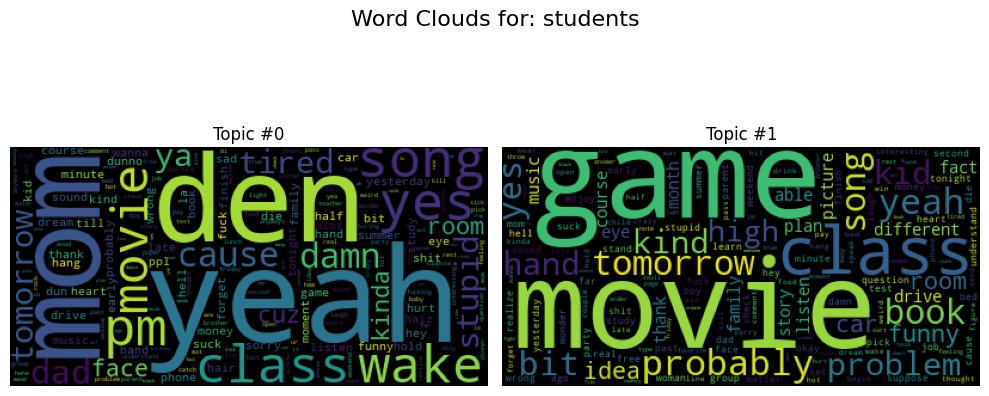

In [97]:
# LDA evaluation - Word Clouds
from wordcloud import WordCloud
import matplotlib.pyplot as plt

for key, data in lda_data.items():
    curr_texts, dictionary, corpus, lda_model, dominant_topics, topics = data
    num_topics = len(lda_model.get_topics())
    rows = (num_topics + 1) // 2

    fig, axes = plt.subplots(rows, 2, figsize=(10, 5 * rows))
    fig.suptitle(f"Word Clouds for: {key}", fontsize=16)

    # If there's only one row, axes may not be 2D, so we ensure it is
    if rows == 1:
        axes = [axes]

    for i, t in enumerate(range(num_topics)):
        ax = axes[i // 2][i % 2]
        ax.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
        ax.axis("off")
        ax.set_title(f"Topic #{t}")

    # Remove any empty subplots
    for j in range(num_topics, rows * 2):
        fig.delaxes(axes[j // 2][j % 2])

    plt.tight_layout()
    plt.show()


In [100]:
from collections import defaultdict

# Function to extract pseudo-clauses mentioning the top words of dominant topics
def extract_pseudo_clauses(documents, dominant_topics, lda_model, num_words=10, window_size=5):
    topic_words = {i: [word for word, prob in lda_model.show_topic(i, topn=num_words)] for i in range(num_topics)}
    topic_clauses = defaultdict(list)

    for doc_idx, doc in enumerate(documents):
        dominant_topic = dominant_topics[doc_idx]
        top_words = topic_words[dominant_topic]

        for i, (token, pos) in enumerate(doc):
            if token in top_words:
                # Extract a window of tokens around the top word
                start = max(i - window_size, 0)
                end = min(i + window_size + 1, len(doc))
                pseudo_clause = " ".join([t for t, p in doc[start:end]])
                topic_clauses[dominant_topic].append(pseudo_clause)

    return topic_clauses

for key, data in lda_data.items():
    curr_texts, dictionary, corpus, lda_model, dominant_topics, topics = data
    topic_clauses = extract_pseudo_clauses(all_preprocessed[key], dominant_topics, lda_model)
    print(f"Pseudo-clauses for [{key}]")
    for topic, clauses in topic_clauses.items():
        print(f"Topic {topic}:")
        for clause in clauses[:5]:
            print(f"- {clause}")
        print("\n")


Pseudo-clauses for [students]
Topic 1:
- dog walk bike ride read book sun take walk regain say
- walk regain say gift movement yes begin training cross country hurt
- way undoubtedly begin mad hunger yes starve dog eat bone thin
- eat bone thin barely survive bit scrap garbage leave feast night
- feed meal day go walkie bit throw ball outside nap physical


Topic 0:
- drive insane artist lisa loeb song thinking crying feel tired everybody
- saliva lolidolidoo gosh bored save damn period pe think crazy b
- end period later ahh m class hah m ground stupid stupid
- bored line call colin peck yeah soo worry make covo worry
- people like uhh liar oh yes know sing song tell gracas




## NTM (Neural Topic Modeling)

Neural topic modeling can leverage GPU architecture to work on a very big collecton of data, Neural Variational Document Model (NVDM) or the more recent BERT-based topic modeling methods.

In [ ]:
# Import necessary libraries
from bertopic import BERTopic

# Function to convert documents to a format suitable for BERTopic
def docs_to_strings(docs):
    """
    Converts a list of documents with (token, pos_tag) tuples into a list of strings.

    :param docs: List of documents, each document is a list of (token, pos_tag) tuples
    :return: List of strings, each string is a document
    """
    return [' '.join([word for word, pos in doc]) for doc in docs]

# Prepare the data for each demographic
docs_strings = {key: docs_to_strings(data) for key, data in all_preprocessed.items()}

# Function to perform neural topic modeling using BERTopic
def perform_neural_topic_modeling(documents):
    """
    Performs neural topic modeling on the provided documents using BERTopic.

    :param documents: List of strings, each string is a document
    :return: BERTopic model and the generated topics
    """
    # Initialize BERTopic
    topic_model = BERTopic()

    # Fit the model on the documents
    topics, probs = topic_model.fit_transform(documents)

    return topic_model, topics

# Perform topic modeling for each demographic
for demographic, docs in docs_strings.items():
    print(f"Neural topic modeling for {demographic}:")
    topic_model, topics = perform_neural_topic_modeling(docs)

    # Display the topics
    print(topic_model.get_topic_info())
    print("\n")

    # Display the top words for each topic
    for topic_idx in topic_model.get_topics():
        if topic_idx == -1:  # Skip the outlier topic
            continue
        topic = topic_model.get_topic(topic_idx)
        print(f"Topic #{topic_idx}:")
        print(" ".join([word for word, _ in topic]))  # Top words
    print("\n")


Neural topic modeling for students:


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

    Topic  Count                                Name  \
0      -1   3084                 -1_go_like_know_get   
1       0    247               0_love_know_feel_life   
2       1    228                    1_den_haha_de_mi   
3       2    122               2_not_like_think_know   
4       3    118               3_bush_kerry_war_iraq   
5       4    108                4_new_like_time_post   
6       5    108                5_kirsten_oh_love_go   
7       6    100               6_song_band_like_good   
8       7     75               7_god_know_think_life   
9       8     73                 8_josh_not_like_lol   
10      9     62                9_game_post_new_blog   
11     10     54               10_go_get_summer_like   
12     11     41           11_roskilly_jon_love_know   
13     12     38              12_go_get_school_today   
14     13     36                     13_na_que_ko_sa   
15     14     35         14_boinking_love_boinke_say   
16     15     33               15_go_get_friend_

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


   Topic  Count                       Name  \
0     -1     17  -1_think_people_book_read   
1      0  19195       0_like_go_know_think   
2      1     56  1_yarn_knit_like_knitting   

                                      Representation  \
0  [think, people, book, read, ap, like, rob, kno...   
1  [like, go, know, think, time, get, good, day, ...   
2  [yarn, knit, like, knitting, stitch, pattern, ...   

                                 Representative_Docs  
0  [hello start netnav class feel free read posti...  
1  [nbsp nbsp tattooed bettie tattooed bettie dar...  
2  [stumble new addiction knitting thing bag maki...  


Topic #0:
like go know think time get good day thing want
Topic #1:
yarn knit like knitting stitch pattern go think work get


